### feature 대상으로 LGBM 학습  
(Developed from dacon_etri_base_mod1.ipynb)

In [6]:
from datetime import datetime

# 현재 날짜 및 시간 가져오기
now = datetime.now()
timestamp = now.strftime("%m%d_%H%M")  # 예: 0517_1530


submission_folder = '/users/user/Desktop/dacon/submission/'
submission_file = f'submission_final_mod4_6_{timestamp}.csv'


In [7]:

import numpy as np 
import pandas as pd 
import glob 
import random 
import os 
import matplotlib.pyplot as plt 
import seaborn as sns 
import ast 
import warnings
warnings.filterwarnings('ignore') 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import torch
import tensorflow as tf


In [8]:
# seed 고정 
SD = 42 
random.seed(SD) 
np.random.seed(SD) 
os.environ['PYTHONHASHSEED'] = str(SD)
tf.random.set_seed(SD)  # TensorFlow 시드 설정

# 파일 경로 설정 - VSCode 상대경로로 변경
# 실제 경로에 맞게 수정 필요
base_folder =  '/users/user/Desktop/ETRI_lifelog_dataset'
folder = '/ch2025_data_items'

data_dir = base_folder + folder 


# Parquet 파일 전체 경로 리스트 
parquet_files = glob.glob(os.path.join(data_dir, 'ch2025_*.parquet')) 

In [9]:
# 파일 이름을 키로, DataFrame을 값으로 저장할 딕셔너리 
lifelog_data = {} 

# 파일별로 읽기 
for file_path in parquet_files: 
    name = os.path.basename(file_path).replace('.parquet', '').replace('ch2025_', '') 
    lifelog_data[name] = pd.read_parquet(file_path) 
    print(f"✅ Loaded: {name}, shape = {lifelog_data[name].shape}") 

# 딕셔너리에 있는 모든 항목을 독립적인 변수로 할당 
for key, df in lifelog_data.items(): 
    globals()[f"{key}_df"] = df 

✅ Loaded: mACStatus, shape = (939896, 3)
✅ Loaded: mActivity, shape = (961062, 3)
✅ Loaded: mAmbience, shape = (476577, 3)
✅ Loaded: mBle, shape = (21830, 3)
✅ Loaded: mGps, shape = (800611, 3)
✅ Loaded: mLight, shape = (96258, 3)
✅ Loaded: mScreenStatus, shape = (939653, 3)
✅ Loaded: mUsageStats, shape = (45197, 3)
✅ Loaded: mWifi, shape = (76336, 3)
✅ Loaded: wHr, shape = (382918, 3)
✅ Loaded: wLight, shape = (633741, 3)
✅ Loaded: wPedo, shape = (748100, 9)


In [10]:
# 메트릭스 파일 읽기
metrics_train = pd.read_csv(base_folder + '/ch2025_metrics_train.csv')
sample_submission = pd.read_csv(base_folder+'/ch2025_submission_sample.csv')

# ✅ 기준 쌍 (subject_id, lifelog_date) 
sample_submission['lifelog_date'] = pd.to_datetime(sample_submission['lifelog_date']) 
test_keys = set(zip(sample_submission['subject_id'], sample_submission['lifelog_date'].dt.date)) 

# ✅ DataFrame 별 timestamp 컬럼 수동 지정 
dataframes = { 
    'mACStatus': (mACStatus_df, 'timestamp'), 
    'mActivity': (mActivity_df, 'timestamp'), 
    'mAmbience': (mAmbience_df, 'timestamp'), 
    'mBle': (mBle_df, 'timestamp'), 
    'mGps': (mGps_df, 'timestamp'), 
    'mLight': (mLight_df, 'timestamp'), 
    'mScreenStatus': (mScreenStatus_df, 'timestamp'), 
    'mUsageStats': (mUsageStats_df, 'timestamp'), 
    'mWifi': (mWifi_df, 'timestamp'), 
    'wHr': (wHr_df, 'timestamp'), 
    'wLight': (wLight_df, 'timestamp'), 
    'wPedo': (wPedo_df, 'timestamp'), 
} 

In [11]:
# ✅ 분리 함수 
def split_test_train(df, subject_col='subject_id', timestamp_col='timestamp'): 
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], errors='coerce') 
    df = df.dropna(subset=[timestamp_col]) 
    df['date_only'] = df[timestamp_col].dt.date 
    df['key'] = list(zip(df[subject_col], df['date_only'])) 
    test_df = df[df['key'].isin(test_keys)].drop(columns=['date_only', 'key']) 
    train_df = df[~df['key'].isin(test_keys)].drop(columns=['date_only', 'key']) 
    return test_df, train_df 


In [12]:
# ✅ 결과 저장 
for name, (df, ts_col) in dataframes.items(): 
    print(f"⏳ {name} 분리 중...") 
    test_df, train_df = split_test_train(df.copy(), subject_col='subject_id', timestamp_col=ts_col) 
    globals()[f"{name}_test"] = test_df 
    globals()[f"{name}_train"] = train_df 
    print(f"✅ {name}_test → {test_df.shape}, {name}_train → {train_df.shape}") 

⏳ mACStatus 분리 중...
✅ mACStatus_test → (335849, 3), mACStatus_train → (604047, 3)
⏳ mActivity 분리 중...
✅ mActivity_test → (343579, 3), mActivity_train → (617483, 3)
⏳ mAmbience 분리 중...
✅ mAmbience_test → (170453, 3), mAmbience_train → (306124, 3)
⏳ mBle 분리 중...
✅ mBle_test → (8140, 3), mBle_train → (13690, 3)
⏳ mGps 분리 중...
✅ mGps_test → (287386, 3), mGps_train → (513225, 3)
⏳ mLight 분리 중...
✅ mLight_test → (34439, 3), mLight_train → (61819, 3)
⏳ mScreenStatus 분리 중...
✅ mScreenStatus_test → (336160, 3), mScreenStatus_train → (603493, 3)
⏳ mUsageStats 분리 중...
✅ mUsageStats_test → (16499, 3), mUsageStats_train → (28698, 3)
⏳ mWifi 분리 중...
✅ mWifi_test → (27467, 3), mWifi_train → (48869, 3)
⏳ wHr 분리 중...
✅ wHr_test → (143311, 3), wHr_train → (239607, 3)
⏳ wLight 분리 중...
✅ wLight_test → (233809, 3), wLight_train → (399932, 3)
⏳ wPedo 분리 중...
✅ wPedo_test → (288832, 9), wPedo_train → (459268, 9)


In [13]:
def process_mACStatus(df): 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    df = df.sort_values(['subject_id', 'timestamp']) 
    results = [] 
    for (subj, date), group in df.groupby(['subject_id', 'date']): 
        status = group['m_charging'].values # 0/1 상태 
        times = group['timestamp'].values # 충전 상태 비율 
        ratio_charging = status.mean() 
        # 상태 전이 횟수 
        transitions = (status[1:] != status[:-1]).sum() 
        # 연속된 1 상태 길이들 
        lengths = [] 
        current_len = 0 
        for val in status: 
            if val == 1: 
                current_len += 1 
            elif current_len > 0: 
                lengths.append(current_len) 
                current_len = 0 
        if current_len > 0: 
            lengths.append(current_len) 
        avg_charging_duration = np.mean(lengths) if lengths else 0 
        max_charging_duration = np.max(lengths) if lengths else 0 
        results.append({ 
            'subject_id': subj, 
            'date': date, 
            'charging_ratio': ratio_charging, 
            'charging_transitions': transitions, 
            'avg_charging_duration': avg_charging_duration, 
            'max_charging_duration': max_charging_duration, 
        }) 
    return pd.DataFrame(results) 

mACStatus_df2 = process_mACStatus(mACStatus_df) 

In [14]:
def process_mActivity(df): 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    summary = [] 
    for (subj, date), group in df.groupby(['subject_id', 'date']): 
        counts = group['m_activity'].value_counts(normalize=True) # 비율 
        row = {'subject_id': subj, 'date': date} 
        # 0~8 비율 저장 
        for i in range(9): 
            row[f'activity_{i}_ratio'] = counts.get(i, 0) 
        # 주요 활동 정보 
        row['dominant_activity'] = group['m_activity'].mode()[0] 
        row['num_unique_activities'] = group['m_activity'].nunique() 
        summary.append(row) 
    return pd.DataFrame(summary) 

mActivity_df2 = process_mActivity(mActivity_df) 

In [15]:
# 지정된 10개 라벨 
top_10_labels = [ 
    "Inside, small room", "Speech", "Silence", "Music", "Narration, monologue", 
    "Child speech, kid speaking", "Conversation", "Speech synthesizer", "Shout", "Babbling" 
] 

def process_mAmbience_top10(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    # 초기화 
    for label in top_10_labels + ['others']: 
        df[label] = 0.0 
    for idx, row in df.iterrows(): 
        parsed = ast.literal_eval(row['m_ambience']) if isinstance(row['m_ambience'], str) else row['m_ambience'] 
        others_prob = 0.0 
        for label, prob in parsed: 
            prob = float(prob) 
            if label in top_10_labels: 
                df.at[idx, label] = prob 
            else: 
                others_prob += prob 
        df.at[idx, 'others'] = others_prob 
    return df.drop(columns=['m_ambience']) 

mAmbience_df2= process_mAmbience_top10(mAmbience_df) 

In [16]:
def summarize_mAmbience_daily(df): 
    prob_cols = [col for col in df.columns if col not in ['subject_id', 'timestamp', 'date']] 
    # 하루 단위로 평균값 요약 
    daily_summary = df.groupby(['subject_id', 'date'])[prob_cols].mean().reset_index() 
    return daily_summary 

mAmbience_df2 = summarize_mAmbience_daily(mAmbience_df2) 


In [17]:
def process_mBle(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    features = [] 
    for idx, row in df.iterrows(): 
        entry = ast.literal_eval(row['m_ble']) if isinstance(row['m_ble'], str) else row['m_ble'] 
        rssi_list = [] 
        class_0_cnt = 0 
        class_other_cnt = 0 
        for device in entry: 
            try: 
                rssi = int(device['rssi']) 
                rssi_list.append(rssi) 
                if str(device['device_class']) == '0': 
                    class_0_cnt += 1 
                else: 
                    class_other_cnt += 1 
            except: 
                continue # malformed record 
        feature = { 
            'subject_id': row['subject_id'], 
            'date': row['date'], 
            'device_class_0_cnt': class_0_cnt, 
            'device_class_others_cnt': class_other_cnt, 
            'device_count': len(rssi_list), 
            'rssi_mean': np.mean(rssi_list) if rssi_list else np.nan, 
            'rssi_min': np.min(rssi_list) if rssi_list else np.nan, 
            'rssi_max': np.max(rssi_list) if rssi_list else np.nan, 
        } 
        features.append(feature) 
    return pd.DataFrame(features) 

In [18]:
def summarize_mBle_daily(df): 
    # row 단위 BLE feature 추출 
    df = process_mBle(df) 
    # 하루 단위로 cnt 합치기 
    grouped = df.groupby(['subject_id', 'date']).agg({ 
        'device_class_0_cnt': 'sum', 
        'device_class_others_cnt': 'sum', 
        'rssi_mean': 'mean', 
        'rssi_min': 'min', 
        'rssi_max': 'max', 
    }).reset_index() 
    # 총합 구해서 비율 계산 
    total_cnt = grouped['device_class_0_cnt'] + grouped['device_class_others_cnt'] 
    grouped['device_class_0_ratio'] = grouped['device_class_0_cnt'] / total_cnt.replace(0, np.nan) 
    grouped['device_class_others_ratio'] = grouped['device_class_others_cnt'] / total_cnt.replace(0, np.nan) 
    # 필요 없는 원래 cnt 컬럼 제거 
    grouped.drop(columns=['device_class_0_cnt', 'device_class_others_cnt'], inplace=True) 
    return grouped 

mBle_df2 = summarize_mBle_daily(mBle_df) 

In [19]:
def process_mGps(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    features = [] 
    for idx, row in df.iterrows(): 
        gps_list = ast.literal_eval(row['m_gps']) if isinstance(row['m_gps'], str) else row['m_gps'] 
        altitudes = [] 
        latitudes = [] 
        longitudes = [] 
        speeds = [] 
        for entry in gps_list: 
            try: 
                altitudes.append(float(entry['altitude'])) 
                latitudes.append(float(entry['latitude'])) 
                longitudes.append(float(entry['longitude'])) 
                speeds.append(float(entry['speed'])) 
            except: 
                continue 
        features.append({ 
            'subject_id': row['subject_id'], 
            'date': row['date'], 
            'altitude_mean': np.mean(altitudes) if altitudes else np.nan, 
            'latitude_std': np.std(latitudes) if latitudes else np.nan, 
            'longitude_std': np.std(longitudes) if longitudes else np.nan, 
            'speed_mean': np.mean(speeds) if speeds else np.nan, 
            'speed_max': np.max(speeds) if speeds else np.nan, 
            'speed_std': np.std(speeds) if speeds else np.nan, 
        }) 
    return pd.DataFrame(features) 

In [20]:
m_Gps_df2 = process_mGps(mGps_df) 
m_Gps_df2 = m_Gps_df2.groupby(['subject_id', 'date']).agg({ 
    'altitude_mean': 'mean', 
    'latitude_std': 'mean', 
    'longitude_std': 'mean', 
    'speed_mean': 'mean', 
    'speed_max': 'max', 
    'speed_std': 'mean' 
}).reset_index() 

In [21]:
def process_mLight(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    df['hour'] = df['timestamp'].dt.hour 
    # 밤(22~05시), 낮(06~21시) 구분 
    df['is_night'] = df['hour'].apply(lambda h: h >= 22 or h < 6) 
    # 하루 단위 요약 
    daily = df.groupby(['subject_id', 'date']).agg( 
        light_mean=('m_light', 'mean'), 
        light_std=('m_light', 'std'), 
        light_max=('m_light', 'max'), 
        light_min=('m_light', 'min'), 
        light_night_mean=('m_light', lambda x: x[df.loc[x.index, 'is_night']].mean()), 
        light_day_mean=('m_light', lambda x: x[~df.loc[x.index, 'is_night']].mean()), 
        light_night_ratio=('is_night', 'mean') # 밤 시간 측정 비율 
    ).reset_index() 
    return daily 

mLight_df2 = process_mLight(mLight_df) 

In [22]:
def process_mScreenStatus(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    features = [] 
    for (subj, date), group in df.groupby(['subject_id', 'date']): 
        status = group['m_screen_use'].values 
        ratio_on = status.mean() 
        transitions = (status[1:] != status[:-1]).sum() 
        # 연속된 1 상태 길이들 
        durations = [] 
        current = 0 
        for val in status: 
            if val == 1: 
                current += 1 
            elif current > 0: 
                durations.append(current) 
                current = 0 
        if current > 0: 
            durations.append(current) 
        features.append({ 
            'subject_id': subj, 
            'date': date, 
            'screen_on_ratio': ratio_on, 
            'screen_on_transitions': transitions, 
            'screen_on_duration_avg': np.mean(durations) if durations else 0, 
            'screen_on_duration_max': np.max(durations) if durations else 0, 
        }) 
    return pd.DataFrame(features) 

mScreenStatus_df2 = process_mScreenStatus(mScreenStatus_df) 


In [23]:
top_apps = [ 
    'One UI 홈', '카카오톡', '시스템 UI', 'NAVER', '캐시워크', 
    '성경일독Q', 'YouTube', '통화', '메시지', '타임스프레드', 'Instagram'
] 

def process_mUsageStats(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    features = [] 
    for (subj, date), group in df.groupby(['subject_id', 'date']): 
        app_time = {app: 0 for app in top_apps} 
        others_time = 0 
        for row in group['m_usage_stats']: 
            parsed = ast.literal_eval(row) if isinstance(row, str) else row 
            for entry in parsed: 
                app = entry.get('app_name') 
                time = entry.get('total_time', 0) 
                if app in top_apps: 
                    app_time[app] += int(time) 
                else: 
                    others_time += int(time) 
        feature = { 
            'subject_id': subj, 
            'date': date, 
            'others_time': others_time 
        } 
        # 각 앱별 컬럼 추가 
        feature.update({f'{app}_time': app_time[app] for app in top_apps}) 
        features.append(feature) 
    return pd.DataFrame(features) 

mUsageStats_df2 = process_mUsageStats(mUsageStats_df) 

In [24]:

def process_mWifi(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    results = [] 
    for (subj, date), group in df.groupby(['subject_id', 'date']): 
        rssi_all = [] 
        for row in group['m_wifi']: 
            parsed = ast.literal_eval(row) if isinstance(row, str) else row 
            for ap in parsed: 
                try: 
                    rssi = int(ap['rssi']) 
                    rssi_all.append(rssi) 
                except: 
                    continue 
        results.append({ 
            'subject_id': subj, 
            'date': date, 
            'wifi_rssi_mean': np.mean(rssi_all) if rssi_all else np.nan, 
            'wifi_rssi_min': np.min(rssi_all) if rssi_all else np.nan, 
            'wifi_rssi_max': np.max(rssi_all) if rssi_all else np.nan, 
            'wifi_detected_cnt': len(rssi_all) 
        }) 
    return pd.DataFrame(results) 

mWifi_df2 = process_mWifi(mWifi_df) 

In [25]:

def get_time_block(hour): 
    if 0 <= hour < 6: 
        return 'early_morning' 
    elif 6 <= hour < 12: 
        return 'morning' 
    elif 12 <= hour < 18: 
        return 'afternoon' 
    else: 
        return 'evening' 

def process_wHr_by_timeblock(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    df['block'] = df['timestamp'].dt.hour.map(get_time_block) 
    results = [] 
    for (subj, date), group in df.groupby(['subject_id', 'date']): 
        block_stats = {'subject_id': subj, 'date': date} 
        for block, block_group in group.groupby('block'): 
            hr_all = [] 
            for row in block_group['heart_rate']: 
                parsed = ast.literal_eval(row) if isinstance(row, str) else row 
                hr_all.extend([int(h) for h in parsed if h is not None]) 
            if not hr_all: 
                continue 
            above_100 = [hr for hr in hr_all if hr > 100] 
            block_stats[f'hr_{block}_mean'] = np.mean(hr_all) 
            block_stats[f'hr_{block}_std'] = np.std(hr_all) 
            block_stats[f'hr_{block}_max'] = np.max(hr_all) 
            block_stats[f'hr_{block}_min'] = np.min(hr_all) 
            block_stats[f'hr_{block}_above_100_ratio'] = len(above_100) / len(hr_all) 
        results.append(block_stats) 
    return pd.DataFrame(results) 

wHr_df2 = process_wHr_by_timeblock(wHr_df) 

In [26]:

def process_wLight_by_timeblock(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    df['block'] = df['timestamp'].dt.hour.map(get_time_block) 
    results = [] 
    for (subj, date), group in df.groupby(['subject_id', 'date']): 
        block_stats = {'subject_id': subj, 'date': date} 
        for block, block_group in group.groupby('block'): 
            lux = block_group['w_light'].dropna().values 
            if len(lux) == 0: 
                continue 
            block_stats[f'wlight_{block}_mean'] = np.mean(lux) 
            block_stats[f'wlight_{block}_std'] = np.std(lux) 
            block_stats[f'wlight_{block}_max'] = np.max(lux) 
            block_stats[f'wlight_{block}_min'] = np.min(lux) 
        results.append(block_stats) 
    return pd.DataFrame(results) 

wLight_df2 = process_wLight_by_timeblock(wLight_df)

In [27]:
def process_wPedo(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    summary = df.groupby(['subject_id', 'date']).agg({ 
        'step': 'sum', 
        'step_frequency': 'mean', 
        'distance': 'sum', 
        'speed': ['mean', 'max'], 
        'burned_calories': 'sum' 
    }).reset_index() 
    # 컬럼 이름 정리 
    summary.columns = ['subject_id', 'date', 'step_sum', 'step_frequency_mean', 'distance_sum', 'speed_mean', 'speed_max', 'burned_calories_sum'] 
    return summary 

wPedo_df2 = process_wPedo(wPedo_df) 

In [28]:

from functools import reduce 
df_list = [ 
    mACStatus_df2, 
    mActivity_df2, 
    mAmbience_df2, 
    mBle_df2, 
    m_Gps_df2, 
    mLight_df2, 
    mScreenStatus_df2, 
    mUsageStats_df2, 
    mWifi_df2, 
    wHr_df2, 
    wLight_df2, 
    wPedo_df2 
] 

merged_df = reduce(lambda left, right: pd.merge(left, right, on=['subject_id', 'date'], how='outer'), df_list) 


In [29]:

# metrics_train의 lifelog_date → datetime.date 형으로 변환 
metrics_train['lifelog_date'] = pd.to_datetime(metrics_train['lifelog_date']).dt.date 

# merged_df의 date도 변환 
merged_df['date'] = pd.to_datetime(merged_df['date']).dt.date 

# 1. date 기준 정렬을 위해 metrics_train의 lifelog_date -> date로 맞추기 
metrics_train_renamed = metrics_train.rename(columns={'lifelog_date': 'date'}) 

# 2. train_df: metrics_train과 일치하는 (subject_id, date) → 라벨 포함 
train_df = pd.merge(metrics_train_renamed, merged_df, on=['subject_id', 'date'], how='inner') 

# 3. test_df: metrics_train에 없는 (subject_id, date) 
merged_keys = merged_df[['subject_id', 'date']] 
train_keys = metrics_train_renamed[['subject_id', 'date']] 
test_keys = pd.merge(merged_keys, train_keys, on=['subject_id', 'date'], how='left', indicator=True) 
test_keys = test_keys[test_keys['_merge'] == 'left_only'].drop(columns=['_merge']) 
test_df = pd.merge(test_keys, merged_df, on=['subject_id', 'date'], how='left') 


In [30]:

# ✅ 타겟 리스트 
targets_binary = ['Q1', 'Q2', 'Q3', 'S2', 'S3'] 
target_multiclass = 'S1' 

# ✅ feature 준비 
X = train_df.drop(columns=['subject_id', 'sleep_date', 'date', 'Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']) 
X.fillna(0, inplace=True) # 결측값 처리 

test_X = test_df.drop(columns=['subject_id', 'date']) 
test_X.fillna(0, inplace=True) 


In [31]:

# 컬럼 이름에서 특수 문자 제거/변환 
def sanitize_column_names(df): 
    df.columns = ( 
        df.columns 
        .str.replace(r"[^\w]", "_", regex=True) # 특수문자 → _ 
        .str.replace(r"__+", "_", regex=True) # 연속된 _ 제거 
        .str.strip("_") # 앞뒤 _ 제거 
    ) 
    return df 

# 모든 입력에 적용 
X = sanitize_column_names(X) 
test_X = sanitize_column_names(test_X) 

In [32]:
# 모든 특성에 대해 모델링 진행 
X_selected = X.copy()
test_X_selected = test_X.copy()

In [33]:
# LightGBM 라이브러리 임포트
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping 

# GridSearch를 위한 교차 검증 설정
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# LightGBM 기본 파라미터 설정
lgbm_params = {
    'n_estimators': 1000,
    'learning_rate': 0.03,
    'random_state': 42,
    'n_jobs': -1,
    'verbosity': -1
}



In [34]:
# -------------------------------- # 
# [그리드서치 적용 X] 
# 이진 분류
binary_preds_selected = {}
binary_models_selected = {}  # 모델 객체 저장용 딕셔너리 (for Feature-Importance)


for col in targets_binary:
    print(f">> {col} 변수 진행 중..")
    y = train_df[col]
    # 이진 분류용 파라미터 조정
    binary_params = lgbm_params.copy()
    binary_params['objective'] = 'binary'
    
    model = LGBMClassifier(**binary_params)
    model.fit(X_selected, y)
    binary_preds_selected[col] = model.predict(test_X_selected)
    binary_models_selected[col] = model  # 여기에 모델 저장

# 다중 분류 (S1)
print(">> S1 변수 진행 중..")

y_multi = train_df['S1']
# 다중 분류용 파라미터 설정 (클래스 수 추가)
multiclass_params = lgbm_params.copy()
multiclass_params['num_class'] = len(y_multi.unique())

model_s1_selected = LGBMClassifier(**multiclass_params)
model_s1_selected.fit(X_selected, y_multi)  
multiclass_pred_selected = model_s1_selected.predict(test_X_selected)


>> Q1 변수 진행 중..
>> Q2 변수 진행 중..
>> Q3 변수 진행 중..
>> S2 변수 진행 중..
>> S3 변수 진행 중..
>> S1 변수 진행 중..


In [36]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Find available Korean fonts on your system
korean_fonts = [f.name for f in fm.fontManager.ttflist if 'Gothic' in f.name or 'Malgun' in f.name]
print("Available Korean fonts:", korean_fonts)

# Use Malgun Gothic (common on Windows)
plt.rcParams['font.family'] = 'Malgun Gothic'
# or try: plt.rcParams['font.family'] = 'Microsoft JhengHei'

Available Korean fonts: ['Century Gothic', 'Hancom Gothic', 'Franklin Gothic Medium', 'Malgun Gothic', 'Yu Gothic', 'Malgun Gothic', 'HYGothic-Medium', 'Yu Gothic', 'Century Gothic', 'HYGothic-Extra', 'Century Gothic', 'Hancom Gothic', 'Yu Gothic', 'Yu Gothic', 'MS Gothic', 'Century Gothic', 'Franklin Gothic Medium', 'Malgun Gothic']


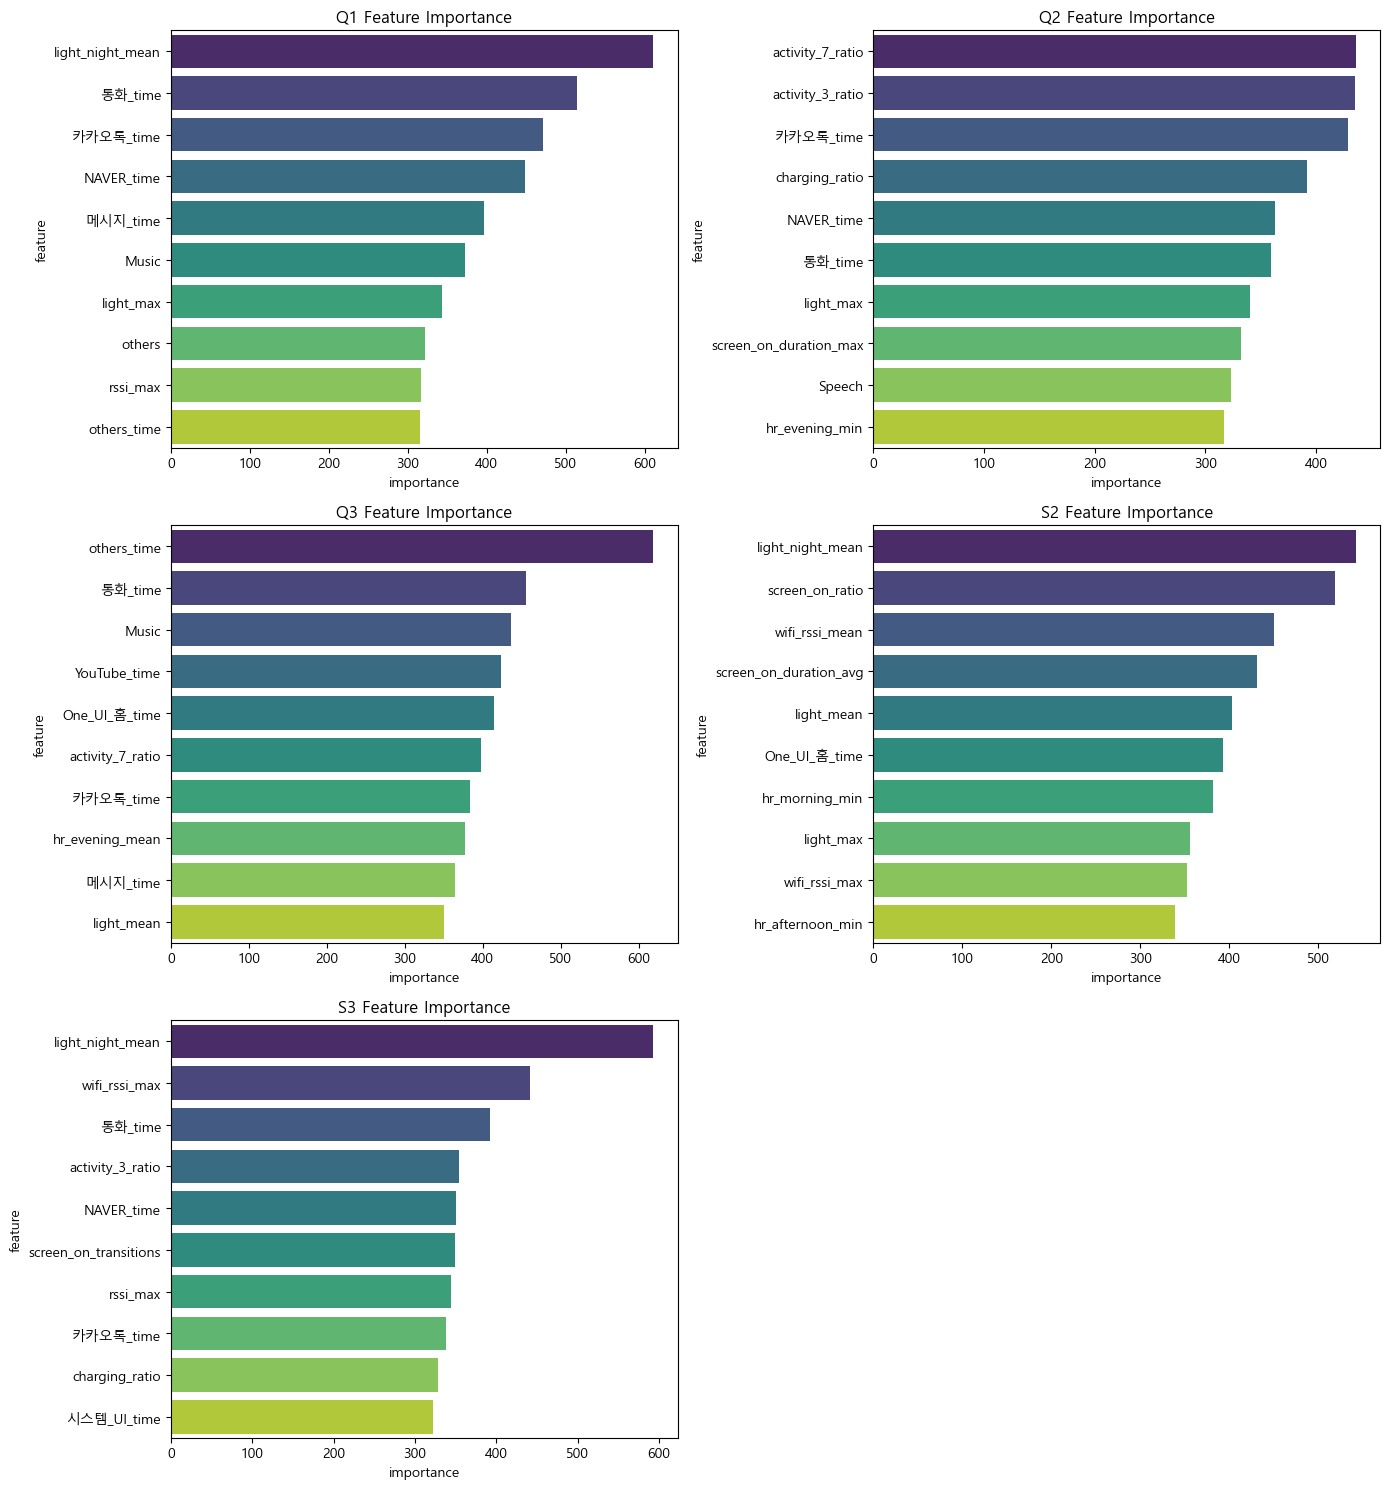

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

top_features_binary = set() # feature top 10 

# subplot 수 계산
n_models = len(binary_models_selected)
n_cols = 2  # 한 줄에 두 개씩
n_rows = math.ceil(n_models / n_cols)

# subplot 생성
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 5 * n_rows))
axes = axes.flatten()  # 2D -> 1D 배열로 변환

for idx, (col_name, model) in enumerate(binary_models_selected.items()):
    importance_df = pd.DataFrame({
        'feature': X_selected.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False).head(10)  # 상위 10개만 표시

    # 📌 상위 feature들을 set에 추가
    top_features_binary.update(importance_df['feature'].unique())


    sns.barplot(
        x='importance', y='feature', 
        data=importance_df, ax=axes[idx], palette='viridis' 
    )
    axes[idx].set_title(f'{col_name} Feature Importance')

# 남은 빈 subplot 제거
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [38]:
# 📌 결과 출력
top_features_binary = list(top_features_binary)
print("📌 전체 모델에서 등장한 상위 10개 feature들의 unique 목록:")
print(top_features_binary) 
print("📌 feature unique 갯수:")
print(len(top_features_binary))

📌 전체 모델에서 등장한 상위 10개 feature들의 unique 목록:
['시스템_UI_time', '통화_time', 'light_mean', 'One_UI_홈_time', 'screen_on_duration_avg', 'wifi_rssi_mean', 'screen_on_transitions', '카카오톡_time', 'Music', 'others_time', 'others', 'light_night_mean', 'activity_7_ratio', 'rssi_max', 'hr_morning_min', 'hr_afternoon_min', 'hr_evening_min', 'light_max', '메시지_time', 'screen_on_duration_max', 'NAVER_time', 'hr_evening_mean', 'Speech', 'wifi_rssi_max', 'YouTube_time', 'activity_3_ratio', 'screen_on_ratio', 'charging_ratio']
📌 feature unique 갯수:
28


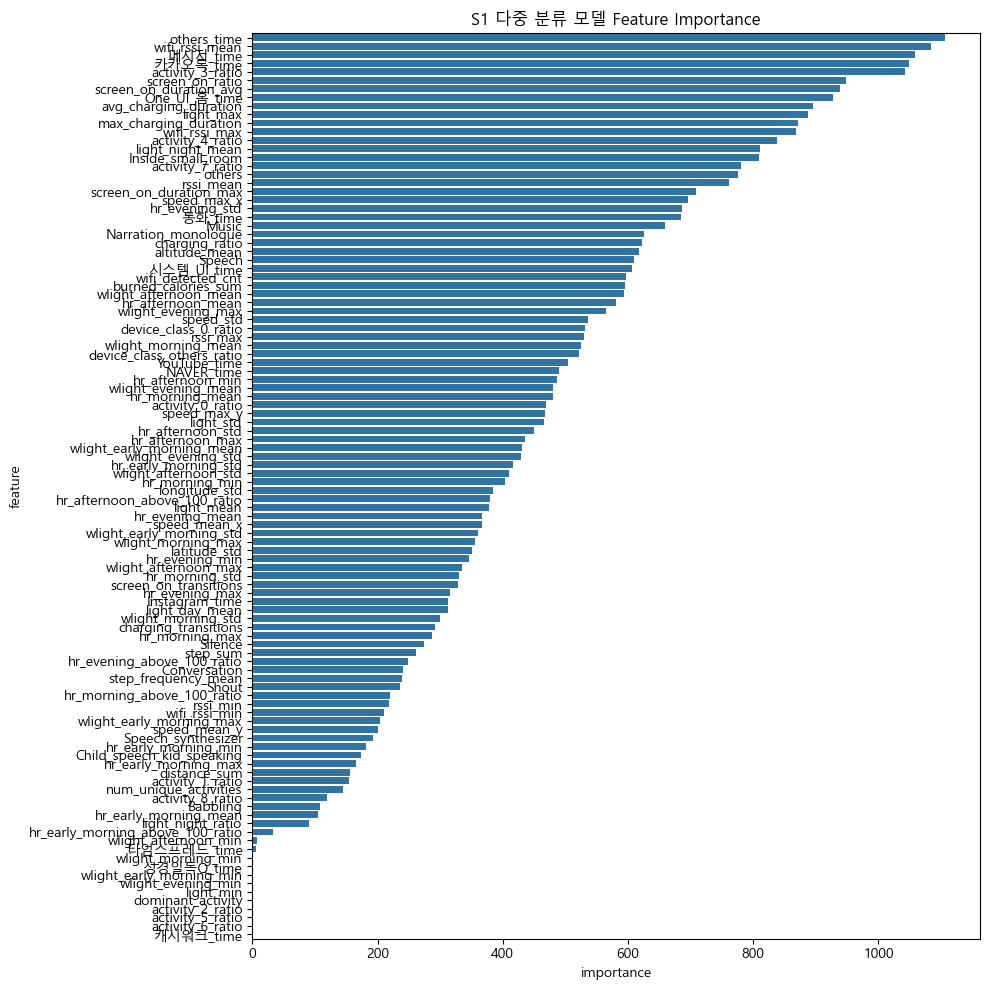

In [39]:
# 중요도 추출  
fi_multi = pd.DataFrame({
    'feature': X_selected.columns,
    'importance': model_s1_selected.feature_importances_
}).sort_values('importance', ascending=False)

# top 10 features
fi_multi_10 = pd.DataFrame({
    'feature': X_selected.columns,
    'importance': model_s1_selected.feature_importances_
}).sort_values('importance', ascending=False).head(10)


# 시각화
plt.figure(figsize=(10, 10))
sns.barplot(x='importance', y='feature', data=fi_multi)
plt.title('S1 다중 분류 모델 Feature Importance')
plt.tight_layout()
plt.show()

In [40]:
# 📌 결과 출력
top_features_multi = fi_multi_10['feature'].tolist()

print("📌 다중분류(S1) 모델에서 등장한 상위 10개 feature들의 unique 목록:")
print(top_features_multi)  # 정렬은 선택사항
print("📌 feature unique 갯수:")
print(len(top_features_multi))

📌 다중분류(S1) 모델에서 등장한 상위 10개 feature들의 unique 목록:
['others_time', 'wifi_rssi_mean', '메시지_time', '카카오톡_time', 'activity_3_ratio', 'screen_on_ratio', 'screen_on_duration_avg', 'One_UI_홈_time', 'avg_charging_duration', 'light_max']
📌 feature unique 갯수:
10


In [41]:
important_features = list(set(top_features_binary + top_features_multi))
print("갯수 :", len(important_features))
print(important_features)

갯수 : 29
['시스템_UI_time', '통화_time', 'light_mean', 'One_UI_홈_time', 'wifi_rssi_mean', 'screen_on_transitions', '카카오톡_time', 'Music', 'others', 'others_time', 'light_night_mean', 'activity_7_ratio', 'rssi_max', 'hr_morning_min', 'hr_afternoon_min', 'hr_evening_min', 'light_max', '메시지_time', 'screen_on_duration_max', 'activity_3_ratio', 'NAVER_time', 'hr_evening_mean', 'Speech', 'wifi_rssi_max', 'YouTube_time', 'screen_on_duration_avg', 'screen_on_ratio', 'charging_ratio', 'avg_charging_duration']


In [42]:
# 선택된 특성만으로 데이터셋 구성
X_selected = X[important_features]
test_X_selected = test_X[important_features]

In [43]:
# LightGBM 라이브러리 임포트
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

# GridSearch를 위한 교차 검증 설정
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# LightGBM 기본 파라미터 설정
lgbm_params = { 
    'n_estimators': 1000, # 
    'learning_rate': 0.03,
    'random_state': 42,
    'n_jobs': -1,
    'verbosity': -1
}


# 이진 분류 모델 성능 향상을 위한 그리드 서치 파라미터
binary_param_grid = {
    'learning_rate': [0.01, 0.03],
    'n_estimators': [500, 1000],
    'num_leaves': [50, 100],
    'max_depth': [-1, 5],
    'min_child_samples': [10, 30],
    # 'reg_alpha': [0, 0.01, 0.1],
    # 'reg_lambda': [0, 0.01, 0.1],
}

# 다중 분류 모델 성능 향상을 위한 그리드 서치 파라미터
multi_param_grid = {
    'learning_rate': [0.01, 0.03],
    'n_estimators': [500, 1000],
    'num_leaves': [50, 100],
    'max_depth': [-1, 5],
    'min_child_samples': [10, 30],
    # 'reg_alpha': [0, 0.01, 0.1],
    # 'reg_lambda': [0, 0.01, 0.1],
}

In [44]:
print("\n===== 오토인코더를 사용한 고급 특성 추출 =====")

# 하이퍼파라미터 설정
encoding_dim = min(64, X_selected.shape[1])  # 인코딩 차원 (원본 특성 수보다 작게 설정)
batch_size = 64
epochs = 100

# 입력 차원
input_dim = X_selected.shape[1]

# 오토인코더 모델 구축
input_layer = Input(shape=(input_dim,))

# 인코더 부분
encoded = Dense(128, activation='relu')(input_layer)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.3)(encoded)
encoded = Dense(64, activation='relu')(encoded)
encoded = BatchNormalization()(encoded)
encoded = Dense(encoding_dim, activation='relu')(encoded)

# 디코더 부분
decoded = Dense(64, activation='relu')(encoded)
decoded = BatchNormalization()(decoded)
decoded = Dropout(0.3)(decoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = BatchNormalization()(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

# 전체 오토인코더 모델
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# 인코더 부분만 추출 (특성 추출용)
encoder = Model(input_layer, encoded)



===== 오토인코더를 사용한 고급 특성 추출 =====


In [45]:
# 훈련/검증 세트 분리
X_train_auto, X_val_auto = train_test_split(X_selected, test_size=0.2, random_state=42)

# 조기 종료 설정
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# 오토인코더 모델 학습
print("오토인코더 학습 중...")
autoencoder.fit(
    X_train_auto, X_train_auto,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(X_val_auto, X_val_auto),
    callbacks=[early_stopping],
    verbose=1
)

# 인코딩된 특성 추출
print("인코딩된 특성 추출 중...")
encoded_features_train = encoder.predict(X_selected)
encoded_features_test = encoder.predict(test_X_selected)

# 원본 특성과 인코딩된 특성 결합
X_combined = np.hstack([X_selected, encoded_features_train])
test_X_combined = np.hstack([test_X_selected, encoded_features_test])

print(f"원본 특성 수: {X_selected.shape[1]}")
print(f"인코딩된 특성 수: {encoded_features_train.shape[1]}")
print(f"결합된 특성 수: {X_combined.shape[1]}")


오토인코더 학습 중...
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - loss: 9501263527936.0000 - val_loss: 10742222815232.0000
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 9501263527936.0000 - val_loss: 10742222815232.0000
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 9501263527936.0000 - val_loss: 10742222815232.0000
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 9501263527936.0000 - val_loss: 10742222815232.0000
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 9501263527936.0000 - val_loss: 10742222815232.0000
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 9501263527936.0000 - val_loss: 10742222815232.0000
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 9501263527936.0000 - val_loss: 10742222815232.0000
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 9501263527936.0000 - val_loss: 10742222815232.0000
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 9501263527936.0000 - val_loss: 10742222815232.0000
Epoch

In [47]:
# ------------------ 결합된 특성으로 이진 분류 모델 학습 ------------------

# 이진 분류 모델 최적화 및 학습
binary_preds_combined = {}
for col in targets_binary:
    y = train_df[col]
    
    # 이진 분류용 모델 설정
    binary_model = LGBMClassifier(objective='binary', **lgbm_params)
    
    # 그리드 서치로 최적 파라미터 찾기
    grid_search = GridSearchCV(
        estimator=binary_model,
        param_grid=binary_param_grid,
        scoring='f1',  # 또는 'roc_auc', 'precision', 'recall' 등 문제에 적합한 지표 선택
        cv=cv,
        verbose=1,
        n_jobs=-1
    )
    
    print(f"\n{col} 이진 분류 모델 최적화 중 (결합된 특성 사용)...")
    grid_search.fit(X_combined, y)
    
    print(f"최적 파라미터: {grid_search.best_params_}")
    print(f"최고 점수: {grid_search.best_score_:.4f}")
    
    # 최적 모델로 예측
    best_model = grid_search.best_estimator_
    binary_preds_combined[col] = best_model.predict(test_X_combined)


Q1 이진 분류 모델 최적화 중 (결합된 특성 사용)...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
최적 파라미터: {'learning_rate': 0.01, 'max_depth': 5, 'min_child_samples': 30, 'n_estimators': 1000, 'num_leaves': 50}
최고 점수: 0.5930

Q2 이진 분류 모델 최적화 중 (결합된 특성 사용)...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
최적 파라미터: {'learning_rate': 0.03, 'max_depth': 5, 'min_child_samples': 30, 'n_estimators': 500, 'num_leaves': 50}
최고 점수: 0.6551

Q3 이진 분류 모델 최적화 중 (결합된 특성 사용)...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
최적 파라미터: {'learning_rate': 0.01, 'max_depth': -1, 'min_child_samples': 30, 'n_estimators': 500, 'num_leaves': 50}
최고 점수: 0.7198

S2 이진 분류 모델 최적화 중 (결합된 특성 사용)...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
최적 파라미터: {'learning_rate': 0.03, 'max_depth': 5, 'min_child_samples': 10, 'n_estimators': 1000, 'num_leaves': 50}
최고 점수: 0.7791

S3 이진 분류 모델 최적화 중 (결합된 특성 사용)...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
최적 파라미터: {'lea

In [48]:
# ------------------ 결합된 특성으로 다중 분류 모델 학습 ------------------

# 다중 분류 (S1) 모델 최적화 및 학습
y_multi = train_df['S1']
n_classes = len(y_multi.unique())

# 다중 분류용 모델 설정
multiclass_model = LGBMClassifier(objective='multiclass', num_class=n_classes, **lgbm_params)

# 그리드 서치로 최적 파라미터 찾기
grid_search_multi = GridSearchCV(
    estimator=multiclass_model,
    param_grid=multi_param_grid,
    scoring='f1_macro',  # 다중 분류에서는 macro 평균 사용
    cv=cv,
    verbose=1,
    n_jobs=-1
)

print("\nS1 다중 분류 모델 최적화 중 (결합된 특성 사용)...")
grid_search_multi.fit(X_combined, y_multi)

print(f"최적 파라미터: {grid_search_multi.best_params_}")
print(f"최고 점수: {grid_search_multi.best_score_:.4f}")

# 최적 모델로 예측
best_multi_model = grid_search_multi.best_estimator_
multiclass_pred_combined = best_multi_model.predict(test_X_combined)

# 검증 데이터에 대한 성능 평가
X_train_comb, X_val_comb, y_train, y_val = train_test_split(
    X_combined, y_multi, test_size=0.2, random_state=42, stratify=y_multi
)

# 최적 파라미터를 사용하여 검증용 모델 학습
eval_model_comb = LGBMClassifier(**grid_search_multi.best_params_)
eval_model_comb.fit(X_train_comb, y_train)

# 예측 및 평가
y_pred_comb = eval_model_comb.predict(X_val_comb)

print("\n===== 오토인코더 + LightGBM 결합 모델 평가 (S1) =====")
print(classification_report(y_val, y_pred_comb))
print("\n혼동 행렬:")
print(confusion_matrix(y_val, y_pred_comb))



S1 다중 분류 모델 최적화 중 (결합된 특성 사용)...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
최적 파라미터: {'learning_rate': 0.01, 'max_depth': -1, 'min_child_samples': 30, 'n_estimators': 500, 'num_leaves': 50}
최고 점수: 0.3864

===== 오토인코더 + LightGBM 결합 모델 평가 (S1) =====
              precision    recall  f1-score   support

           0       0.46      0.38      0.42        29
           1       0.58      0.71      0.64        45
           2       0.36      0.25      0.30        16

    accuracy                           0.52        90
   macro avg       0.47      0.45      0.45        90
weighted avg       0.50      0.52      0.51        90


혼동 행렬:
[[11 16  2]
 [ 8 32  5]
 [ 5  7  4]]


In [49]:
# ------------------ 성능 비교 분석 ------------------

# 원본 특성만 사용한 모델과 결합 특성 모델 비교
print("\n===== 원본 특성 vs 결합 특성 모델 성능 비교 =====")

# 원본 특성 모델 재학습 (비교용)
X_train_orig, X_val_orig, y_train, y_val = train_test_split(
    X_selected, y_multi, test_size=0.2, random_state=42, stratify=y_multi
)

eval_model_orig = LGBMClassifier(**grid_search_multi.best_params_)
eval_model_orig.fit(X_train_orig, y_train)
y_pred_orig = eval_model_orig.predict(X_val_orig)

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# 정확도 비교
acc_orig = accuracy_score(y_val, y_pred_orig)
acc_comb = accuracy_score(y_val, y_pred_comb)
print(f"정확도 - 원본 특성: {acc_orig:.4f}, 결합 특성: {acc_comb:.4f}, 향상: {(acc_comb-acc_orig)*100:.2f}%")

# F1 점수 비교 (다중 분류는 macro 평균)
f1_orig = f1_score(y_val, y_pred_orig, average='macro')
f1_comb = f1_score(y_val, y_pred_comb, average='macro')
print(f"F1 점수 - 원본 특성: {f1_orig:.4f}, 결합 특성: {f1_comb:.4f}, 향상: {(f1_comb-f1_orig)*100:.2f}%")


===== 원본 특성 vs 결합 특성 모델 성능 비교 =====
정확도 - 원본 특성: 0.5444, 결합 특성: 0.5222, 향상: -2.22%
F1 점수 - 원본 특성: 0.4749, 결합 특성: 0.4505, 향상: -2.45%


In [50]:
# sample 기반 제출 포맷 가져오기
submission_final = sample_submission[['subject_id', 'sleep_date', 'lifelog_date']].copy()

# lifelog_date 기준으로 string → date 형식 통일
submission_final['lifelog_date'] = pd.to_datetime(submission_final['lifelog_date']).dt.date

# ID 만들기 (submission에서 예측한 결과와 연결하기 위해)
submission_final['ID'] = submission_final['subject_id'] + '_' + submission_final['lifelog_date'].astype(str)

In [51]:

# 예측 결과 연결할 수 있도록 동일한 순서로 정렬
# 보통 예측 결과는 test_df 기준이므로 정렬 보장되어야 함
assert len(submission_final) == len(multiclass_pred_combined) # shape 체크

# 다중 분류 예측 붙이기
submission_final['S1'] = multiclass_pred_combined

# 이진 분류 결과 붙이기
for col in ['Q1', 'Q2', 'Q3', 'S2', 'S3']:
    submission_final[col] = binary_preds_combined[col].astype(int) # 확률 아닌 class 예측


In [52]:

# 최종 제출 형식 정렬
submission_final = submission_final[['subject_id', 'sleep_date', 'lifelog_date', 'Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']]

# 저장
submission_final.to_csv(submission_folder + submission_file, index=False)

# VSCode에서는 files.download()가 작동하지 않으므로 대체

print(f"✅ 제출 파일이 저장되었습니다: {os.path.abspath(submission_file)}")

✅ 제출 파일이 저장되었습니다: c:\Users\user\Desktop\submission_final_mod4_6_0601_2224.csv
